<a href="https://colab.research.google.com/github/replicable/euaiact/blob/main/quantify_duplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai --quiet
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np, pandas as pd, re
from openai import AzureOpenAI

PATH = "/content/drive/MyDrive/eu_ai_act/"
client = AzureOpenAI(
  api_key = "...",
  api_version = "2023-05-15",
  azure_endpoint = "..."
)

# get GPT3 embedding from a string
def get_embedding(text, model="text-embedding-3-small"):
  return client.embeddings.create(input = [text], model=model).data[0].embedding

# split each article/annex to a list of paragraphs, typically starting with '(number). '
def get_para(ct):
  cts = str(ct).split('\n')
  paras, para, i = [], '', 0
  for line in cts:
    if para and line.strip().split('. ')[0].replace('.', '').isdigit():
      paras.append(para)
      para = ''
    para += line.strip() + '\n'
  paras.append(para.strip())
  return paras


###########################
# process ai_act corpus   #
###########################
df0 = pd.read_excel(PATH + "ai_act.xlsx", sheet_name='articles')
df1 = pd.read_excel(PATH + "ai_act.xlsx", sheet_name='paragraphs')
subjects_ai, contents_ai = df0['heading'].tolist(), df0['content'].tolist()
subjects_ai = [re.sub(r'', '', s) for s in subjects_ai]
subjects_ai1, contents_ai1 = df1['heading'].tolist(), df1['paragraph'].tolist()
lens_ai = len(subjects_ai)
paras_ai = [[] for _ in range(lens_ai)]
count = 0
for i in range(lens_ai):
  while count < len(contents_ai1) and subjects_ai1[count] == i:
    paras_ai[i].append(contents_ai1[count])
    count += 1


###########################
# process prod_reg corpus #
###########################
df_heading = pd.read_excel(PATH + "prod_reg.xlsx", sheet_name='heading')
df_content = pd.read_excel(PATH + "prod_reg.xlsx", sheet_name='content')
prods = df_heading.columns.tolist()
headings, contents = dict(zip(prods, [[] for _ in prods])), dict(zip(prods, [[] for _ in prods]))
subjects, artnos = dict(zip(prods, [[] for _ in prods])), dict(zip(prods, [[] for _ in prods]))
paras = dict(zip(prods, [[] for _ in prods]))
lens = dict(zip(prods, [0 for _ in prods]))

for prod in prods:
  headings[prod], contents[prod] = df_heading[prod].tolist(), df_content[prod].tolist()

  # trim NaN
  while headings[prod] and not isinstance(headings[prod][-1], str):
    headings[prod].pop()
    contents[prod].pop()
  lens[prod] = len(headings[prod])

  # get subjects (subject matters) and artnos (numbers) for each article/annex
  for i in range(lens[prod]):
    subject, artno = '', ''
    for chunk in headings[prod][i].split(';'):
      c = chunk.split('. ')
      subject += '/' + (''.join(c[1:]) if len(c) > 1 else c[0])
      c0 = c[0].replace('Article ', '').replace('ANNEX ', 'A').replace('CHAPTER ', '')
      c0 = c0.replace('PART ', '').replace('Part ', '')
      c0 = c0.replace('Appendix ', 'App').replace('PRELIMINARY OBSERVATIONS', 'PO')
      artno += '/' + c0
    subjects[prod].append(subject[1:])
    artnos[prod].append(artno[1:])

  # get paras (a list of paragraphs)
  paras[prod] = [get_para(ct) for ct in contents[prod]]

In [ ]:
####################################################
# get GPT3 embeddings and cosine similarity scores #
####################################################
subjects_ai_embed = [get_embedding(sm) for sm in subjects_ai]
contents_ai_embed = [get_embedding(ct) for ct in contents_ai]

In [ ]:
subjects_embed = dict(zip(prods, [[get_embedding(sm) for sm in subjects[prod]] for prod in prods]))

In [ ]:
contents_embed = dict(zip(prods, [[get_embedding(str(ct) if ct else ' ') for ct in contents[prod]] for prod in prods]))

In [ ]:
subjects_sim = dict(zip(prods, [[[np.dot(subject_ai_embed, subject_embed) for subject_embed in subjects_embed[prod]] for subject_ai_embed in subjects_ai_embed] for prod in prods]))
contents_sim = dict(zip(prods, [[[(np.dot(content_ai_embed, contents_embed[prod][i]) if isinstance(contents[prod][i], str) else 0) for i in range(len(contents[prod]))] for content_ai_embed in contents_ai_embed] for prod in prods]))

In [ ]:
###############################################################################
# get most similar pairs of articles/annexes between AI Act and each prod reg #
###############################################################################
top_ids = dict(zip(prods, [[[] for _ in range(lens_ai)] for prod in prods]))
top_headings = dict(zip(prods, [['' for _ in range(lens_ai)] for prod in prods]))
for prod in prods:
  for i in range(lens_ai):
    sim_ct = contents_sim[prod][i]
    tops = sorted(range(len(sim_ct)), reverse=True, key=lambda k: sim_ct[k])[:2]
    sims = [a + b for a, b in zip(subjects_sim[prod][i], contents_sim[prod][i])]
    tops += sorted(range(len(sims)), reverse=True, key=lambda k: sims[k])[:2]
    headings = []
    for top in set(tops):
      top_ids[prod][i].append(top)
      headings.append(str(artnos[prod][top]))
    top_headings[prod][i] = ', '.join(headings)
result = pd.DataFrame(top_headings)
result.to_excel(PATH + 'top_articles.xlsx', index=False)

In [ ]:
#########################################
# get embeddings from AI Act paragraphs #
#########################################
para_ai_embed = [[get_embedding(para_ai if para_ai else ' ') for para_ai in paras_ai[i]] for i in range(lens_ai)]

In [ ]:
#########################################################################
# get most similar pairs of paragraphs between AI Act and each prod reg #
#########################################################################
final_sims = dict(zip(prods, [[[] for _ in range(lens_ai)] for prod in prods]))
caches = dict(zip(prods, [[[[] for _ in para] for para in paras[prod]] for prod in prods]))
records = dict(zip(prods, [[] for prod in prods]))
for prod in prods:
  for i in range(lens_ai):
    for j in range(len(paras_ai[i])):
      if paras_ai[i][j] == '':
        final_sims[prod][i].append(0)
        continue
      para_top, sim_top, id_top = '', 0, -np.inf
      for id in top_ids[prod][i]:
        for k in range(len(paras[prod][id])):
          p = paras[prod][id][k]
          if p == '':
            continue
          if caches[prod][id][k] != []:
            emb = caches[prod][id][k]
          else:
            emb = caches[prod][id][k] = get_embedding(p)
          simil = np.dot(para_ai_embed[i][j], emb)
          if simil > sim_top:
            para_top = paras[prod][id][k]
            sim_top = simil
            id_top = id
      final_sims[prod][i].append(sim_top)
      records[prod].append([subjects_ai[i], paras_ai[i][j], artnos[prod][id_top], para_top, sim_top])
with pd.ExcelWriter(PATH + 'top_paragraphs.xlsx') as writer:
  for prod in prods:
    pd.DataFrame(records[prod]).to_excel(writer, sheet_name=prod, index=False)

In [ ]:
####################################
# get potential duplication scores #
####################################
mean = dict(zip(prods, [[0 for _ in range(lens_ai)] for prod in prods]))
ter1 = dict(zip(prods, [[0 for _ in range(lens_ai)] for prod in prods]))
ter2 = dict(zip(prods, [[0 for _ in range(lens_ai)] for prod in prods]))
ter3 = dict(zip(prods, [[0 for _ in range(lens_ai)] for prod in prods]))
for prod in prods:
  for i in range(lens_ai):
    count, counts = 0, 0
    for j in range(len(paras_ai[i])):
      count = len(paras_ai[i][j])
      counts += count
      mean[prod][i] += final_sims[prod][i][j] * count
      ter1[prod][i] += (final_sims[prod][i][j] > 2/3) * 1 / len(paras_ai[i])
      ter2[prod][i] += (1/2 < final_sims[prod][i][j] <= 2/3) * 1 / len(paras_ai[i])
      ter3[prod][i] += (final_sims[prod][i][j] <= 1/2) * 1 / len(paras_ai[i])
    mean[prod][i] /= counts
with pd.ExcelWriter(PATH + 'outcome.xlsx') as writer:
  pd.DataFrame(mean).to_excel(writer, sheet_name='mean', index=False)
  pd.DataFrame(ter1).to_excel(writer, sheet_name='1st', index=False)
  pd.DataFrame(ter2).to_excel(writer, sheet_name='2nd', index=False)
  pd.DataFrame(ter3).to_excel(writer, sheet_name='3rd', index=False)

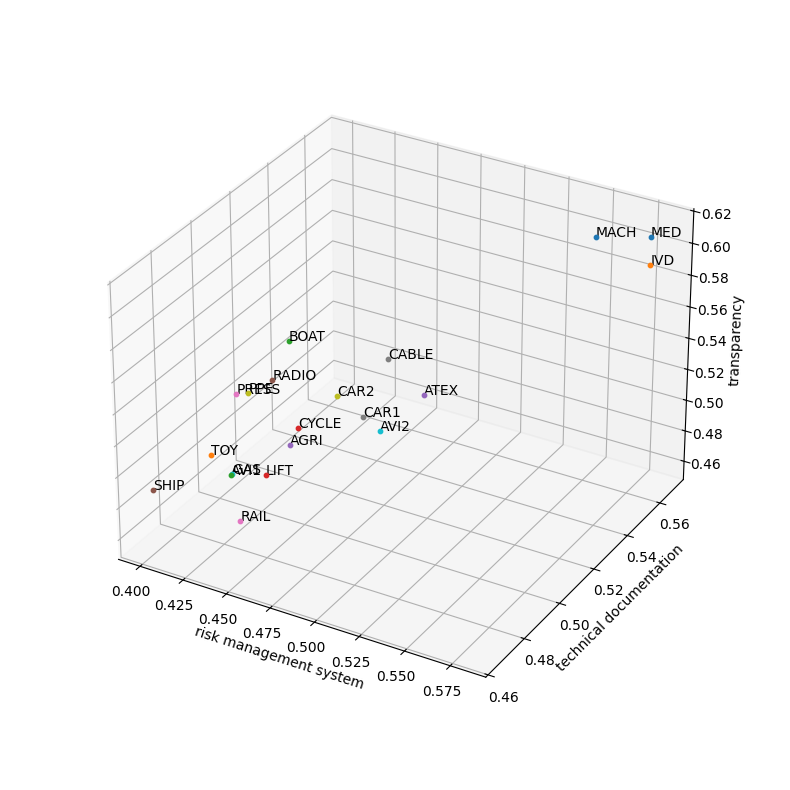

In [ ]:
#####################################
# plot potential duplication scores #
#####################################
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
for prod in prods:
  x = mean[prod][0]
  y = (mean[prod][2] * len(contents_ai[2]) + mean[prod][3] * len(contents_ai[3])) / len(contents_ai[2] + contents_ai[3])
  z = mean[prod][5]
  ax.scatter(x, y, z, s=10,label=prod)
  ax.text(x, y, z, prod, size=10)
ax.set_xlabel("risk management system")
ax.set_ylabel("technical documentation")
ax.set_zlabel("transparency")
ax.set_box_aspect(None, zoom=0.85)
plt.show()

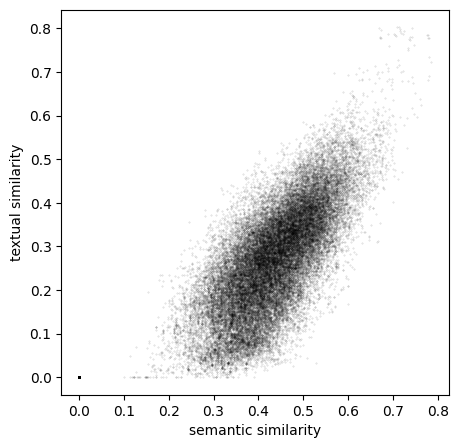

In [ ]:
##########################################################################
# Measure correlation between textual similarity and semantic similarity #
##########################################################################
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
for prod in prods:
  contents_ai_cleaned = [str(x) if not pd.isnull(x) else '' for x in contents_ai]
  contents_prod_cleaned = [str(x) if not pd.isnull(x) else '' for x in contents[prod]]
  c = contents_ai_cleaned + contents_prod_cleaned
  sim_textual = cosine_similarity(TfidfVectorizer().fit_transform(c),
                                  TfidfVectorizer().fit_transform(c))
  ax.scatter(contents_sim[prod], sim_textual[:24, 24:], s=0.1, c='black', alpha=0.2)
ax.set_xlabel("semantic similarity")
ax.set_ylabel("textual similarity")
plt.show()